In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import shutil
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scipy.io
import json
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
from tqdm import tqdm
from modules.data_preprocessing import data_reallocation, create_datasets
from modules.train_classfier import train, test_eval


/Users/antonkutsenko/Documents/Nova IMS/AML_course/Project/modules/train_classfier.py:63: SyntaxWarning: invalid escape sequence '\A'
  print(f"Train: Epoch [{epoch+1}/{num_epochs}], \nStep [{counter}/{len(train_loader)}], \nLoss: {loss.item():.4f}, n\Accuracy: {(100 * correct / total):.4f}")
/Users/antonkutsenko/Documents/Nova IMS/AML_course/Project/modules/train_classfier.py:88: SyntaxWarning: invalid escape sequence '\L'
  print(f"Val: Epoch [{epoch+1}/{num_epochs}], n\Loss: {(running_loss / len(val_loader)):.4f}, n\Accuracy: {(100 * correct / total):.4f}")
/Users/antonkutsenko/Documents/Nova IMS/AML_course/Project/modules/train_classfier.py:88: SyntaxWarning: invalid escape sequence '\A'
  print(f"Val: Epoch [{epoch+1}/{num_epochs}], n\Loss: {(running_loss / len(val_loader)):.4f}, n\Accuracy: {(100 * correct / total):.4f}")


In [2]:
# Define paths
data_path = 'flower102'
images_path = os.path.join(data_path, 'images')
output_path = 'data'

data_reallocation(data_path, 
                  images_path,
                  output_path)

train_dataset, val_dataset, test_dataset = create_datasets(output_path, batch_size=32)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Images reallocated successfully to folder data


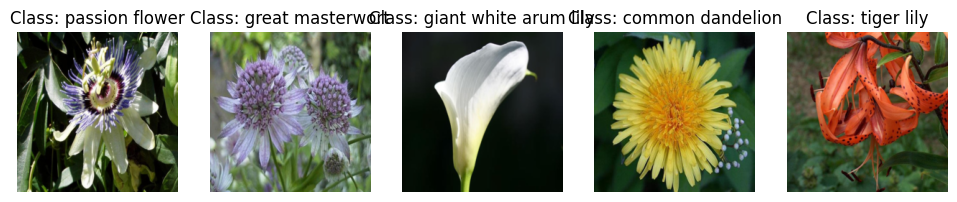

In [3]:
# plot 4 images from data
swapped_dict = {value: key for key, value in train_dataset.class_to_idx.items()}
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for ax in axes:
    picture_number = random.randint(0, len(train_dataset))
    image = train_dataset[picture_number][0].permute(1, 2, 0)
    #unnormalize
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    ax.imshow(image)
    ax.set_title(f"Class: {swapped_dict[train_dataset[picture_number][1]]}")
    ax.axis('off')


In [ ]:
model = torchvision.models.resnet18(pretrained=True)
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss()
path_to_save_model = 'model.pth'
lr = 0.01
num_classes = len(train_loader.dataset.classes)

In [ ]:
train(train_loader, 
      val_loader, 
      model = model,
      num_epochs=num_epochs, 
      device = device,
      criterion=criterion,
      optimizer=optimizer,
      lr=lr, 
      path_to_save_model=path_to_save_model,
      num_classes=num_classes)

KeyboardInterrupt: 

In [ ]:
test_eval(test_loader,
    model = model,
    device = device,
    path_to_save_model = path_to_save_model)

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

# Calculate accuracy and F1-score for each class
class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
class_f1 = []

for i in range(num_classes):
  precision = cm[i, i] / np.sum(cm[:, i]) if np.sum(cm[:,i]) > 0 else 0
  recall = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i,:]) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
  class_f1.append(f1)



  0%|          | 0/32 [00:00<?, ?it/s]

In [13]:
# Find the class with the worst accuracy and F1-score
worst_accuracy_class = np.argmin(class_accuracy)
worst_f1_class = np.argmin(class_f1)

print(f"Class with worst accuracy: {worst_accuracy_class}, Accuracy: {class_accuracy[worst_accuracy_class]}")
print(f"Class with worst F1-score: {worst_f1_class}, F1-score: {class_f1[worst_f1_class]}")

# Find the classes it was mostly confused with
# For the class with the worst accuracy:
confusion_dist = cm[worst_accuracy_class]
top_confused_classes_acc = np.argsort(confusion_dist)[::-1][:4] # Get top 3
print(f"Top 3 classes confused with (accuracy): {top_confused_classes_acc}")


# For the class with the worst f1-score:
confusion_dist = cm[worst_f1_class]
top_confused_classes_f1 = np.argsort(confusion_dist)[::-1][:4] # Get top 3
print(f"Top 3 classes confused with (F1): {top_confused_classes_f1}")


Class with worst accuracy: 38, Accuracy: 0.1
Class with worst F1-score: 38, F1-score: 0.18181818181818182
Top 3 classes confused with (accuracy): [72 77 42 73]
Top 3 classes confused with (F1): [72 77 42 73]


AttributeError: 'Flowers102' object has no attribute 'classes'

In [21]:
# prompt: remap classes to real names /content/data/flowers-102/imagelabels.mat

import scipy.io
mat = scipy.io.loadmat('/content/data/flowers-102/imagelabels.mat')

class_names = [f'class_{i}' for i in mat['labels'][0] - 1]


In [24]:
class_names = [
    'angelonia', 'anemone', 'antirrhinum', 'aquilegia', 'armeria', 'asters', 'balsam',
    'begonia', 'bluebell', 'buttercup', 'cineraria', 'columbine', 'coreopsis', 'cornflower',
    'cyclamen', 'dahlia', 'daffodil', 'daisy', 'delphinium', 'geranium', 'gladiolus', 'hellebore',
    'hollyhock', 'hydrangea', 'impatiens', 'iris', 'jasmine', 'kenilworth', 'larkspur', 'lilac',
    'lily', 'lupine', 'magnolia', 'marigold', 'morning glory', 'narcissus', 'pansy', 'passion flower',
    'peony', 'petunia', 'phlox', 'poppy', 'primrose', 'primula', 'rudbeckia', 'snowdrop', 'sunflower',
    'sweet pea', 'tiger lily', 'torenia', 'tulip', 'violet', 'wallflower', 'water lily', 'windflower'
]

In [17]:
# Find positions of class 35 in all_labels
class_35_positions = [i for i, label in enumerate(all_labels) if label == 35]

# Get all predictions for those positions
preds_for_class_35 = [all_preds[i] for i in class_35_positions]

print(f"Positions of class 35 in all_labels: {class_35_positions}")
print(f"Predictions for those positions: {preds_for_class_35}")

Positions of class 35 in all_labels: [317, 450, 749]
Predictions for those positions: [35, 36, 40]


In [20]:

# Load the pre-trained ResNet50 model
model = torchvision.models.resnet50(pretrained=False) #pretrained=False because we load our weights
num_classes = 102
model.fc = nn.Linear(model.fc.in_features, num_classes)


# Load the model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/content/drive/MyDrive/AML/initial_model_weights.pth', map_location=device))
model.to(device)

# Set the model to evaluation mode
model.eval()

# Initialize variables to store predictions and true labels
all_preds = []
all_labels = []

# Iterate over the test data loader
with torch.no_grad():
  for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    # Get predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Store predictions and true labels
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Calculate metrics (e.g., accuracy)
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy}")

print(classification_report(all_labels, all_preds))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-20-21e61c5f15a8>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

  0%|          | 0/193 [00:00<?, ?it/s]

KeyboardInterrupt: 